In [3]:
import os
import cv2

import numpy as np
import PIL.Image as img

import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models

In [55]:
IMAGESHAPE = (128,128)
m = keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2")
])

m.build([None, 128, 128, 3])

In [7]:
! wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Lemon.jpg/640px-Lemon.jpg

--2024-05-18 11:18:17--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Lemon.jpg/640px-Lemon.jpgn
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2024-05-18 11:18:18 ERROR 400: Bad Request.



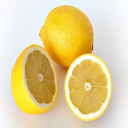

In [15]:
lemon = img.open('640px-Lemon.jpg').resize(IMAGESHAPE)
lemon

In [17]:
lemon_np = np.array(lemon)/255.0

In [20]:
lemon_np = np.expand_dims(lemon_np,axis=0)

In [21]:
lemon_np.shape

(1, 128, 128, 3)

In [24]:
pred = m.predict(lemon_np)

1/1 [==============================] - 0s 27ms/step


In [25]:
np.argmax(pred)

952

In [32]:
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = keras.utils.get_file('flower_photos', origin=url, cache_dir='.', untar=True)

In [33]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [36]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/tulips/13513851673_9d813dc7b0.jpg'),
 PosixPath('datasets/flower_photos/tulips/4550117239_5907aaba4c.jpg'),
 PosixPath('datasets/flower_photos/tulips/18270448366_d5676dec64_z.jpg'),
 PosixPath('datasets/flower_photos/tulips/4516198427_0e5099cd8e.jpg'),
 PosixPath('datasets/flower_photos/tulips/8711277462_b43df5454b_m.jpg')]

In [77]:
flower_dict = {
    'daisy' : list(data_dir.glob('daisy/*.jpg')),
    'dandelion' : list(data_dir.glob('dandelion/*.jpg')),
    'roses' : list(data_dir.glob('roses/*.jpg')),
    'sunflowers' : list(data_dir.glob('sunflowers/*.jpg')),
    'tulip' : list(data_dir.glob('tulip/*.jpg'))
}

flower_lable_dict = {
    'daisy' : 0,
    'dandelion' : 1,
    'roses' : 2,
    'sunflowers' : 2,
    'tulip' : 4
}

In [39]:
flower_dict['roses'][:3]

[PosixPath('datasets/flower_photos/roses/6053143173_991c011b23.jpg'),
 PosixPath('datasets/flower_photos/roses/5526964611_76ef13025c_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5333437251_ce0aa6925d_n.jpg')]

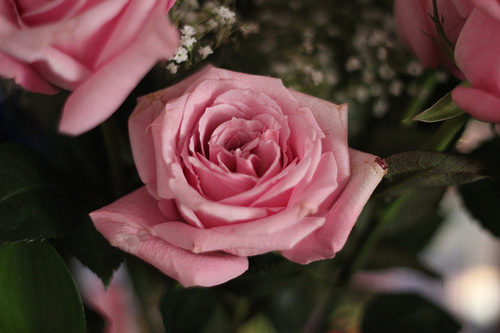

In [41]:
img.open(flower_dict['roses'][0])

array([[[ 75,  61, 139],
        [ 45,  32, 113],
        [ 45,  33, 109],
        ...,
        [110,  95, 169],
        [100,  89, 164],
        [ 52,  42, 131]],

       [[ 77,  64, 140],
        [ 50,  34, 116],
        [ 34,  19, 102],
        ...,
        [106,  95, 167],
        [111, 100, 172],
        [ 83,  74, 151]],

       [[ 79,  65, 141],
        [ 52,  39, 120],
        [ 34,  19, 103],
        ...,
        [102,  95, 162],
        [114, 104, 171],
        [107,  96, 168]],

       ...,

       [[ 12,  44,  29],
        [ 11,  47,  31],
        [ 13,  51,  32],
        ...,
        [ 82,  81,  85],
        [ 66,  63,  72],
        [ 48,  51,  59]],

       [[ 11,  45,  31],
        [ 11,  46,  32],
        [ 12,  48,  32],
        ...,
        [ 69,  67,  73],
        [ 56,  56,  59],
        [ 42,  43,  53]],

       [[ 11,  49,  31],
        [ 12,  47,  32],
        [ 12,  48,  31],
        ...,
        [ 59,  58,  61],
        [ 49,  49,  51],
        [ 41,  41,  50]]], dtype=uint8)
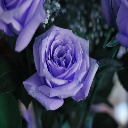

In [46]:
cv_img = cv2.imread(str(flower_dict['roses'][0]))
cv2.resize(cv_img,IMAGESHAPE)

In [78]:
x, y = [], []

for flowers, images in flower_dict.items():
  for image in images:
    im = cv2.imread(str(image))
    im_resize = cv2.resize(im,IMAGESHAPE)
    x.append(im_resize)
    y.append(flower_lable_dict[flowers])

In [67]:
from sklearn.model_selection import train_test_split

In [79]:
x = np.array(x)
y = np.array(y)

In [ ]:
y

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=5)

In [81]:
x_train_scale = x_train/255.0
x_test_scale = x_test/255.0

In [86]:
pred = m.predict(np.array([x[0],x[55],x[555]]))
pred = np.argmax(pred,axis=1)
pred

1/1 [==============================] - 0s 55ms/step


array([689, 689, 905])

In [90]:
feature_extraction = keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-feature-vector/2",
                   trainable=False),  # Can be True, see below.
])

In [94]:
model = keras.Sequential([
    feature_extraction,
    layers.Dense(len(flower_dict))
])

model.compile(
    optimizer='rmsprop',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(x_train_scale,y_train,epochs=5)

Epoch 1/5
53/53 [==============================] - 10s 100ms/step - loss: 0.3288 - accuracy: 0.8725
Epoch 2/5
53/53 [==============================] - 10s 183ms/step - loss: 0.1882 - accuracy: 0.9291
Epoch 3/5
53/53 [==============================] - 6s 109ms/step - loss: 0.1491 - accuracy: 0.9464
Epoch 4/5
53/53 [==============================] - 8s 156ms/step - loss: 0.1290 - accuracy: 0.9529
Epoch 5/5
53/53 [==============================] - 5s 102ms/step - loss: 0.1075 - accuracy: 0.9625


In [95]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 1280)              410208    
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 416613 (1.59 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


In [96]:
model.evaluate(x_test_scale,y_test)

18/18 [==============================] - 2s 97ms/step - loss: 0.1560 - accuracy: 0.9357


[0.1559644490480423, 0.9357143044471741]

In [99]:
pred = model.predict(np.expand_dims(x_test_scale[0],axis=0))

1/1 [==============================] - 1s 556ms/step


array([[-8.059385 , -2.1664464,  5.2824388, -9.244492 , -8.419281 ]],
      dtype=float32)

In [101]:
print(np.argmax(pred))
print(y_test[0])

2
2


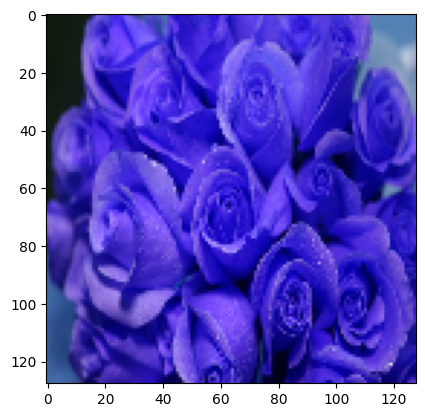

In [108]:
%matplotlib inline
plt.imshow(x_test_scale[0])